<a href="https://colab.research.google.com/github/spatank/CIS-522/blob/main/W2_Tutorial1_SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 2 Part 1
# PyTorch

__Instructor:__ Konrad Kording

__Content creators:__ Ameet Rahane, Spiros Chavlis

---
# Today's agenda
In the first tutorial of Week 2, we are going to learn about PyTorch. As a case study, we will use a simple linear regression model. Today we will:

1. Learn about PyTorch and how to use it
2. Familiarize yourselves with the concept of auto differentiation
3. Implement from scratch a function for linear regression
4. Check the results with an analytical solution

But before we start, let's do a recap of what we have learned in the previous week.

---
# Recap the experience from last week

Video available at https://youtube.com/watch?v=3EuhRYr9uf8


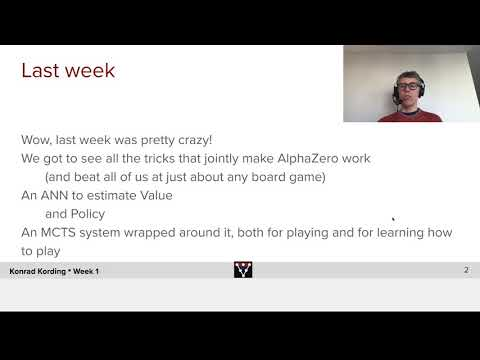

In [147]:
#@title Video: Recap of Week 1
import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="3EuhRYr9uf8", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In [148]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'spatank' #@param {type:"string"}
my_pod = 'sublime-newt' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


Meet with your pod for 10 minutes to discuss what you learned, what was clear, and what you hope to learn more about.

In [149]:
#@markdown Spend 3 minutes telling us on Airtable what the upshot of this discussion is for you.
my_w1_upshot = 'It is reassuring to know that the first week was a lot for other people as well. I was kind of worried that I might be under-prepared for the class because of how fast-paced it already seemed. It is good to know that this was by design on the part of the instructors. ' #@param {type:"string"}


## What do you hope to learn more about this week

Video available at https://youtube.com/watch?v=rs7KaZw-vjU


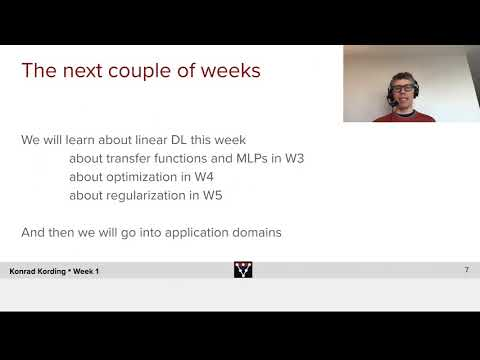

In [150]:
#@title Video: Course Objectives and Short Term Plans

video = YouTubeVideo(id="rs7KaZw-vjU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

We clearly can run code. But now we want to be good enough at this so that we can solve our own problems. And to do so, we need to understand this from the bottom up.

In [151]:
#@markdown write 3 sentences on the main things they hope to get out of the course.
my_expectations = "I want to feel comfortable with the fundamental math behind deep learning. I want to be able to code up a deep learning system from scratch proficiently, and finally I'd like to learn more about the social science and biology applications of deep learning. " #@param {type:"string"}


---
# Setup

In [152]:
# imports
import numpy as np
import random
import matplotlib.pylab as plt
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm, trange

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [153]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# plt.rcParams.update({
#             "text.usetex": False,
#             "font.family": "serif",
#             "font.serif": ["Palatino"],
#             "font.size": 18,
#             })

# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False
# mpl.rcParams['axes.linewidth'] = 2
# mpl.rcParams['ytick.major.width'] = 2
# mpl.rcParams['xtick.major.width'] = 2
# mpl.rcParams['ytick.major.size'] = 7
# mpl.rcParams['xtick.major.size'] = 7

In [154]:
#@title Helper functions

def synthetic_dataset(w, b, num_examples=1000, sigma=0.01, seed=2021):
  '''
  Synthetic data generator in the form:
      y = Xw + b + gaussian_noise(0, sigma).
  
  Parameters
  ----------
  w : torch.tensor
      weights. The length of `w` denotes the number of independent variables
  b : torch.tensor
      bias (offset or intercept).
  num_examples : INT, optional
      DESCRIPTION. The default is 1000.
  sigma : FLOAT, optional
      Standard deviation of the Gaussian noise. The default is 0.01.
  seed : INT, optional
      Seed the RNG for reproducibility. The default is 2021.
  
  Returns
  -------
  X: torch.tensor
      the independent variable(s).
  y: torch.tensor
      the dependent variable
  
  '''

  torch.manual_seed(seed)

  X = torch.normal(0, 1, (w.shape[0], num_examples))
  y = torch.matmul(w.T, X) + b
  # Add gaussian noise
  y += torch.normal(0, sigma, y.shape)

  return X, y.reshape((-1, 1))

---
# Section 1: Intro to PyTorch

Video available at https://youtube.com/watch?v=Murzk7_IAJA


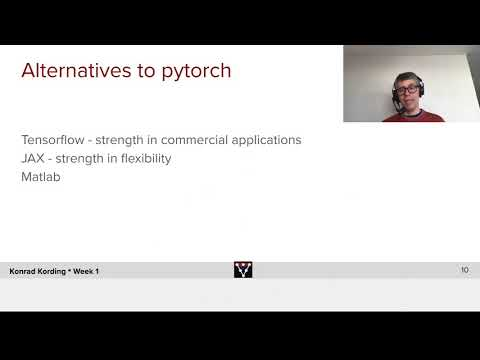

In [155]:
#@title Video: Pytorch is Great

try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="Murzk7_IAJA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## What is PyTorch?

It’s a Python-based scientific computing package targeted at two sets of
audiences:

-  A replacement for NumPy to use the power of GPUs
-  A deep learning platform that provides significant flexibility
   and speed

At its core, PyTorch provides a few key features:

- A multidimensional [Tensor](https://pytorch.org/docs/stable/tensors.html) object, similar to [NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) but with GPU acceleration.
- An optimized **autograd** engine for automatically computing derivatives.
- A clean, modular API for building and deploying **deep learning models**.

You can find more information about PyTorch by following one of the [official tutorials](https://pytorch.org/tutorials/) or by [reading the documentation](https://pytorch.org/docs/1.1.0/).


## Section 1.1: Variable types in Pytorch

`torch.Tensor` is the central class in Pytorch. `torch.Tensor` defines a multi-dimensional matrix containing elements of a single data type (e.g., 32-bit floating points, 8-bit integers, etc.). The different data types can be found [here](https://pytorch.org/docs/stable/tensors.html#:~:text=A%20torch.Tensor%20is%20a,CPU%20tensor). 

Mathematically, a tensor is an algebraic object that defines a multilinear relationship between objects in a vector space. 

By default, `torch.Tensor` creates a *FloatTensor*, or in simple words, a tensor of floats. We can either change the type of a `torch.Tensor` by calling `.type(dtype)` on the Tensor or specify the `dtype` in any function that outputs a tensor. Here are a few examples:

### Exercise 1: PyTorch Tensors
The following bite-sized exercises are rather a tutorial on the basics of PyTorch tensors. Since the solutions are already given, we encourage you to open the *Scratch code cell* from the `Edit` menu, explore each object and see their Docstring (e.g. `? torch.empty`).

**Construct / initialize an empty $5\times3$ matrix:**

In [156]:
x = torch.empty(5, 3)
print(x)

tensor([[3.1660e-33, 0.0000e+00, 1.4013e-45],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.3510e-38]])


As we have seen, even if we have defined an empty matrix, the matrix is not empty, rather it has very large or very low positive values. Why is this?

According to PyTorch's documentation, `torch.empty` returns a tensor filled with *uninitialized data*. Once we call `torch.empty`, a block of memory is allocated according to the `size` (shape) of the tensor. By *uninitialized data*, it's meant that `torch.empty` would simply return the values in the memory block as is. These values could be default values or the values stored in those memory blocks as a result of some other operations used that part of the memory block before.

**Construct a randomly (Standard Normal) initialized matrix:**

In [157]:
x = torch.rand(5, 3)
print(x)

tensor([[0.4749, 0.7931, 0.6834],
        [0.2690, 0.8801, 0.3959],
        [0.1884, 0.3346, 0.1712],
        [0.3603, 0.6813, 0.7850],
        [0.8766, 0.5273, 0.5695]])


**Construct a matrix filled with zeros and of dtype long:**

In [158]:
x = torch.zeros(5, 3, dtype=torch.long)
print(x)

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


**Construct a tensor directly from a list:**

In [159]:
x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


**Construct a tensor-based on an existing tensor:**

These methods will reuse properties of the input tensor, e.g., `dtype`, unless
the user provides new values.

In [160]:
x = x.new_ones(5, 3, dtype=torch.double)      # new_* methods take in sizes
print(x)

x = torch.randn_like(x, dtype=torch.float)    # override dtype!
print(x)                                      # result has the same size

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
tensor([[ 0.3065, -1.1239,  0.8677],
        [-1.1395, -1.0767, -1.5730],
        [ 1.9806, -1.5708,  0.0392],
        [-0.6613, -0.1012,  0.0733],
        [ 1.2772, -0.4890,  1.6097]])


Get its size. 
**Note**: torch.Size is a tuple, so it supports all tuple operations.

In [161]:
print(x.size())

torch.Size([5, 3])


**Declare the data type of tensors**

A previous example shows that even though we initialized the Tensor with `[1, 2, 3]`, it created the Tensor `[1., 2., 3.]`, i.e., instead of integers, we get floats. Why is this?

In [162]:
torch.Tensor([1.,2.,3.5]).type(torch.int32)

tensor([1, 2, 3], dtype=torch.int32)

**Change the data type**

Notice that inputting floats but casting to an integer caused our output Tensor to be different from the input altogether. Change the `dtype` to avoid this from happening.

In [163]:
dtype = torch.float64

torch.Tensor([1.,2.,3.5]).type(dtype)

tensor([1.0000, 2.0000, 3.5000], dtype=torch.float64)

## Section 1.2: Operations
There are multiple syntaxes for operations. In the following example, we will take a look at the addition operation.

Addition: Syntax 1


In [164]:
y = torch.rand(5, 3)
print(x + y)

tensor([[ 0.3294, -1.0575,  1.4797],
        [-0.8657, -0.7362, -1.3924],
        [ 2.8985, -1.0770,  0.7415],
        [ 0.0283,  0.3076,  1.0636],
        [ 1.7692, -0.4100,  1.6133]])


Addition: Syntax 2

In [165]:
print(torch.add(x, y))

tensor([[ 0.3294, -1.0575,  1.4797],
        [-0.8657, -0.7362, -1.3924],
        [ 2.8985, -1.0770,  0.7415],
        [ 0.0283,  0.3076,  1.0636],
        [ 1.7692, -0.4100,  1.6133]])


Addition: Providing an output tensor as argument

In [166]:
result = torch.empty(5, 3)
torch.add(x, y, out=result)
print(result)

tensor([[ 0.3294, -1.0575,  1.4797],
        [-0.8657, -0.7362, -1.3924],
        [ 2.8985, -1.0770,  0.7415],
        [ 0.0283,  0.3076,  1.0636],
        [ 1.7692, -0.4100,  1.6133]])


Addition: In-place

In [167]:
# adds x to y
y.add_(x) # the `_` sign at end means the operation mutates tensor y in-place
print(y)

tensor([[ 0.3294, -1.0575,  1.4797],
        [-0.8657, -0.7362, -1.3924],
        [ 2.8985, -1.0770,  0.7415],
        [ 0.0283,  0.3076,  1.0636],
        [ 1.7692, -0.4100,  1.6133]])


**Read later:**
100+ Tensor operations, including transposing, indexing, slicing, mathematical operations, linear algebra, random numbers, etc., are described [here](http://pytorch.org/docs/torch).

You can use standard NumPy-like indexing with all bells and whistles!

In [168]:
print(x[:, 1])

tensor([-1.1239, -1.0767, -1.5708, -0.1012, -0.4890])


If you want to resize/reshape a tensor, you can use ``torch.view``:

In [169]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])


If you have a one element tensor, use `.item()` to get the value as a
Python number:


In [170]:
x = torch.randn(1)
print(x)
print(x.item())

tensor([1.1340])
1.134012222290039


## Exercise 2: Simple linear operations

### Let's do a few quick refresher problems in linear algebra. Solve the following. 

$$ \textbf{A} = 
\begin{bmatrix}1 & 2 &4 \\5 & 5 & 7 \\ 10 & 15 & 1
\end{bmatrix} * 
\begin{bmatrix}1 & 1 &1 \\2 & 2 & 3 \\ 2 & 3 & 4
\end{bmatrix} 
 + 
\begin{bmatrix}10 & 10 &10 \\20 & 12 & 1 \\ 12 & 32 & 4
\end{bmatrix} 
$$


and


$$ b = 
\begin{bmatrix} 3 \\ 5 \\ 7
\end{bmatrix} \cdot 
\begin{bmatrix} 2 \\ 4 \\ 8
\end{bmatrix}
$$

Now, verify your results with PyTorch (or check your ability to solve by hand via PyTorch!!!)

*Hint:* For matrix multiplication, you can either use `torch.dot`, `torch.matmul`, or `@`. Please explore all three approaches and find their differences.

In [171]:
a1 = torch.tensor([[1, 2, 4], [5, 5, 7], [10, 15, 1]])
a2 = torch.tensor([[1, 1, 1], [2, 2, 3], [2, 3, 4]])
a3 = torch.tensor([[10, 10, 10], [20, 12, 1], [12, 32, 4]])
A = (a1 @ a2) + a3
print(A)
b1 = torch.tensor([3, 5, 7])
b2 = torch.tensor([2, 4, 8])
b = torch.dot(b1, b2)
print(b)

tensor([[23, 27, 33],
        [49, 48, 49],
        [54, 75, 63]])
tensor(82)


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W2_PyTorchDLN/solutions/W2_Tutorial1_Solution_Ex02.py)

*Example output:*  

```python
A = tensor([[23, 27, 33]
            [49, 48, 49],
            [54, 75, 63]])

b = tensor([[82]]) # or b = tensor(82)
```

## Section 1.3: NumPy Bridge

Converting a Torch Tensor to a NumPy array and vice versa is a breeze.

The Torch Tensor and NumPy array will share their underlying memory  
locations, and changing one will change the other.

### Converting a PyTorch Tensor to a NumPy Array

In [172]:
a = torch.ones(5)
print(a)
b = a.numpy()
print(b)

tensor([1., 1., 1., 1., 1.])
[1. 1. 1. 1. 1.]


See how the NumPy array changed in value.

In [173]:
a.add_(1)
print(a)
print(b)

tensor([2., 2., 2., 2., 2.])
[2. 2. 2. 2. 2.]


### Converting NumPy Array to Torch Tensor

See how changing the NumPy array changed the Torch Tensor automatically:

In [174]:
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a)
print(a)
print(b)

[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


As you may know, PyTorch is one of many popular deep learning frameworks for Python. Two honorable mentions are TensorFlow and JAX, both developed by Google but with different preferences in mind. Take 10 minutes to share your experience using a deep learning library (if any) in your group and discuss their significant differences and features. 

**Student response**: Would you prefer flexibility or performance when choosing a deep learning framework and why (feel free to mix and match)?

In [175]:
deep_learning_benchmark = "In CIS 521 and CIS 530, we used PyTorch for a couple homework assignments. I don't have experience with any other packages, but personally I prefer ease of use over either flexibility or performance." #@param {type:"string"}

---
# Section 2: Deep Learning and Gradients

Video available at https://youtube.com/watch?v=uyK1v8VIX4E


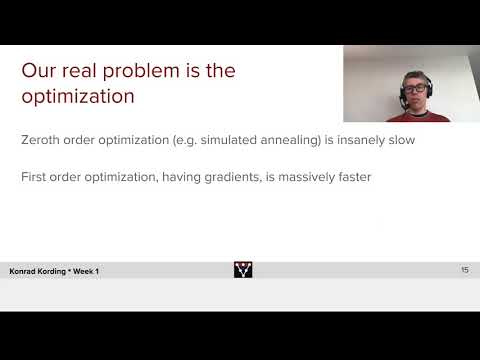

In [176]:
#@title Video: What is Deep Learning

try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="uyK1v8VIX4E", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Why are Gradients important?

The gradient vector can be interpreted as the "direction and rate of fastest increase". In deep learning, we will use the gradient to optimize all of the parameters in a model with respect to some loss function. The partial derivative defines the gradient:

$$\dfrac{\partial loss}{\partial x}$$ where $x$ is the parameter we're optimizing. 

So, what is a partial derivative? Looking back at single variable calculus, we know the ordinary derivative $\dfrac{df}{dx}$. In this function, $df$ is interpreted as some small change in the output of $f$, and $dx$ is is interpreted a small change in $x$.

However, if we have some multivariable function $f(x,y)$, $\dfrac{df}{dx}$ doesn't show how the entire function changes, so we call it a partial derivative, and for the sake of clarity, we denote this as $\dfrac{\partial f}{\partial x}$. When computing this partial derivative, we treat everything that's not what our partial derivative is with respect to as a constant. For example:

Let's compute the partial derivative $\dfrac{\partial f}{\partial x}$ of 
$$f(x,y) = x^2y^3$$. We treat $y$ as a constant while doing this, so this is as simple as invoking the exponent rule from single variable calculus:

$$\dfrac{\partial f}{\partial x} = 2xy^3$$

## Now, work out a few partial derivatives to get the hang of it

#### Given $f(x,y) = x^2 - xy$, find 


1.   $\frac{\partial f}{\partial x}$

2.   $\frac{\partial f}{\partial y}$

#### Given $f(x, y, z) = x - xy + z^2$, find 


1.   $\frac{\partial f}{\partial x}$

2.   $\frac{\partial f}{\partial y}$

3.   $\frac{\partial f}{\partial z}$


#### Given $f(x, y) = x e^{-2y} + x^2y$, find the **second** derivatives

1.   $\frac{\partial ^2f}{\partial x^2}$

2.   $\frac{\partial ^2f}{\partial y^2}$

3.   $\frac{\partial ^2f}{\partial x \partial y}$

4.   $\frac{\partial ^2f}{\partial y \partial x}$






Although gradients are the core to many popular optimization approaches, there exist methods known as *derivative-free optimization* algorithms (Bayesian optimization, coordinate descent, and genetic algorithm, to name a few), which do not require gradient calculation.  
Please take 10 minutes to discuss the problems that can be solved with derivative-free optimization algorithms and their limitations in your group.

**Student response**: Have you ever used a derivative-free optimization algorithm? If yes, tell us which algorithm and what kind of problem.



In [177]:
derivative_free_opt_alg = "I've seen coordinate descent used in a variational inference problem. Instead of needing to compute derivatives, this approach solves multiple equations iteratively to arrive at the optimal parameter values. " #@param {type:"string"}

---
# Section 3: Gradients in Pytorch (Autograd)

Video available at https://youtube.com/watch?v=xBc95BB6Gwo


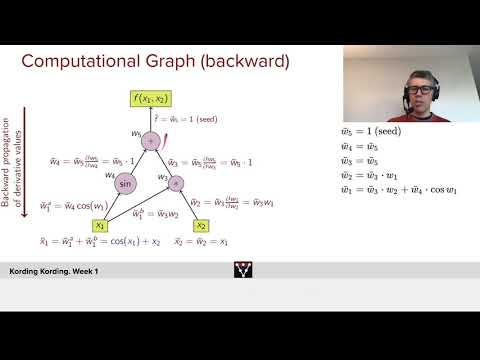

In [178]:
#@title Video: Automatic Differentiation

try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="xBc95BB6Gwo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## AutoGrad

The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a *define-by-run* framework, which means that your backpropagation algorithm is defined by how your code is run and that every single iteration can be different.

Let us see this in more simple terms with some examples.

### Tensors


`torch.Tensor` is the central class of the package. If you set its attribute
`.requires_grad` as `True`, it starts to track all operations on it. When you finish your computation, you can call `.backward()` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into `.grad` attribute.

To stop a tensor from tracking history, you can call `.detach()` to detach it from the computation history and prevent future computation from being tracked.

To prevent tracking history (and use of memory), you can also wrap the code block in `with torch.no_grad():`. This can be particularly helpful when evaluating a model because the model may have trainable parameters with `requires_grad=True`, for which we don't need the gradients.

There’s one more class which is very important for autograd implementation - a `Function`.

<img src="https://miro.medium.com/max/1536/1*wE1f2i7L8QRw8iuVx5mOpw.png" alt="Function" width="600"/>

`Tensor` and `Function` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a `.grad_fn` attribute that references a `Function` that has created the `Tensor` (except for Tensors created by the user - their `grad_fn is None`).

If you want to compute the derivatives, you can call `.backward()` on a `Tensor`. If `Tensor` is a scalar (i.e., it holds a one element (data), you don’t need to specify any arguments to `backward()`, however, if it has more elements, you need to specify a `gradient` argument that is a tensor of matching shape.

On calling `.backward`, we get the gradients $\dfrac{\partial loss}{\partial x}$ where $x$ is the tensor. PyTorch will store the variable results in $x$.

---

PS: In previous versions of PyTorch, this required a separate Variable parameter that acted as a wrapper around a Tensor. This is now depreciated and `pytorch.Tensor` has autograd built-in.

In [179]:
#@markdown **Student response**: Please write down 3 problems where you find autograd is useful.
autograd_uses = 'Since it is a tool for differentiation, it is useful for optimization (finding extrema). It is useful in DL for computing updates to weights.' #@param {type:"string"}

Let's start from some toy examples.

In [180]:
t1 = torch.ones(2, 2, requires_grad=True)
print(t1)

t2 = torch.FloatTensor(3, 3) # No way to specify requires_grad while initiating
t2.requires_grad = True
print(t2)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3.7567e-35, 0.0000e+00, 1.4013e-45],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]], requires_grad=True)


**Important:** `requires_grad` option is *contagious*, i.e., when a Tensor is created by operating on other Tensors, the `requires_grad` of the resultant Tensor would be set `True` given that at least one of the tensors used for its creation has `requires_grad` set to `True`.

*So*, what we have just built is a tensor with the autograd option enabled. As a toy example, assume that we want to differentiate the function $y=4\textbf{x}^{\text{T}}\textbf{x}$ with respect to the column vector $\textbf{x}$.

In [181]:
x = torch.arange(4.0, requires_grad=True)
print(x)
print(x.grad)

tensor([0., 1., 2., 3.], requires_grad=True)
None


Now, we calculate the value of $y$

In [182]:
y = 4 * torch.dot(x, x)
print(y)

tensor(56., grad_fn=<MulBackward0>)


Since $\textbf{x}$ is a vector of length 4, an inner product of $\textbf{x}$ with itself is performed, yielding the scalar output that we assign to $y$. Next, we can automatically calculate the gradient of $y$ with respect to each component of $\textbf{x}$ by calling the function for backpropagation and printing the gradient.

In [183]:
y.backward()
x.grad

tensor([ 0.,  8., 16., 24.])

The gradient of the function  $y=4 \textbf{x}^{\text{T}} \textbf{x}$  with respect to $\textbf{x}$ should be $8\textbf{x}$. Let us quickly verify that our desired gradient was calculated correctly.

In [184]:
x.grad == 8 * x

tensor([True, True, True, True])

In [185]:
# PyTorch accumulates the gradient by default, we need to clear the previous
# values
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Autograd: the importance and history of autograd

Autograd came to be simply because it is impractical and challenging to both visualize and compute gradients for very high dimensional spaces, such as those we'd see in large neural networks: 

> "To deal with hyper-planes in a 14-dimensional space, visualize a 3-D space and say ‘fourteen’ to yourself very loudly. Everyone does it" - Geoffrey Hinton.

Autograd abstracts these concepts and "automagically" calculates gradients of high dimensional spaces. Gradients care calculated by tracing the computation graph from the root (the first tensor created) to the leaf (the last computation that occurred) and using the chain rule to compute every gradient along the way. 

Let's look at some of the relevant functions and attributes:


*   `.detach`: Detaches the tensor from the computation graph and prevents future computation from being tracked
*   `.requires_grad`: Starts tracking all operations on the computation graph
*   `.backward()`: When the computation is finished, call `tensor.backward()` to compute all gradients automatically
*   `.grad`: All of the gradients for each tensor is accumulated in `.grad`
*   `.grad_fn`: For tensors created by an operation, `grad_fn` will give you the operation that created them. For tensors created by users, it will return None. 
*    `.requires_grad_(bool)`: Changes an existing Tensor's `requires_grad` flag in place. This is False by default. 



See: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html


## Example: A small Compute Graph

### Forward pass

PyTorch creates a so-called **Dynamic Computation Graph**, which means that the graph is generated on the fly. 

The big thing that differentiates PyTorch and Tensorflow is how the computation graph functions. In PyTorch, all variables and functions build a dynamic graph of computation. For every mathematical operation involving Tensors, a Function node is made on this computation graph. We can see what function creates a given Tensor by using the attribute `grad_fn`. So, let's examine the compute graph of a simple addition operation.

<img src="https://miro.medium.com/max/1684/1*FDL9Se9otGzz83F3rofQuA.png" alt="Computation Graph" width="500"/>

Here, we give a toy example with an elementary graph to understand PyTorch's logic!

The variables $\alpha$ is the input and is initialized by the user. Variables $b$, $c$ and $d$ are created as a result of mathematical operations, variables $w_1$, $w_2$, $w_3$ and $w_4$ are initialised by the user. Since any mathematical operator does not create them, nodes corresponding to their creation are represented by their name itself. This is true for all the leaf nodes in the graph. Variable $L$ is the output of this computational graph.



#### Exercise 3a: Get the parameters

Lets start by defining our parameters ($w_1, w_2, w_3, w_4$) and inputs ($\alpha$). Lets assume that all parameters and inputs are $3 \times 3$ tensors sampled from a normal distribution with zero mean and standard deviation $\sigma=1$ (i.e., `torch.randn`).

*Hint:* Do not forget to enable tracking of gradients.

In [186]:
def get_params():
  '''
  A simple function that generates our parameters and inputs
  
  ---
  args: nothing

  returns:
    a: torch.Tensor
      inputs
    w1: torch.Tensor
      weights
    w2: torch.Tensor
      weights
    w3: torch.Tensor
      weights
    w4: torch.Tensor
      weights

  '''
  
  a = torch.randn(3, 3, requires_grad = True)
  w1 = torch.randn(3, 3, requires_grad = True)
  w2 = torch.randn(3, 3, requires_grad = True)
  w3 = torch.randn(3, 3, requires_grad = True)
  w4 = torch.randn(3, 3, requires_grad = True)

  return (a, w1, w2, w3, w4)


# uncomment the lines below to test your function
params = get_params()
print(f'The inputs are: \n{params[0]}')
print(f'The weights are: \nw1:{params[1]}, \nw2:{params[2]}, \nw3:{params[3]}, '
      f' \nw4:{params[4]}')

The inputs are: 
tensor([[ 1.4444,  0.8822,  1.2429],
        [ 0.4424, -0.2196, -0.1828],
        [ 2.3049, -0.0150,  1.1266]], requires_grad=True)
The weights are: 
w1:tensor([[ 1.3991,  1.0802, -1.2418],
        [ 0.7012, -0.3298,  0.4720],
        [ 0.5794, -2.6181,  1.0380]], requires_grad=True), 
w2:tensor([[-1.2600, -0.5339,  0.0916],
        [ 0.4557, -0.5489, -1.6517],
        [-0.7078, -1.4285,  1.9632]], requires_grad=True), 
w3:tensor([[ 0.6753, -1.2362,  0.7780],
        [-1.5389, -1.8694, -1.1767],
        [ 0.0346,  0.7962,  1.3760]], requires_grad=True),  
w4:tensor([[ 0.3709, -0.3786, -1.4969],
        [ 0.5509,  1.2205,  0.0647],
        [-0.4909,  0.6569, -0.9372]], requires_grad=True)


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W2_PyTorchDLN/solutions/W2_Tutorial1_Solution_Ex03a.py)

*Example output:*  

The inputs are:
```python
Tensor([[-0.8177, -0.7713, -1.1727],
        [ 0.3594,  0.8547,  0.8028],
        [-1.7355,  0.7635,  0.1232]], requires_grad=True)
```  

The weights are:
```python 
w1:tensor([[ 0.4051,  0.4054,  1.1714],
           [ 0.1003, -0.0375, -1.3340],
           [ 0.0332,  0.8825, -1.2887]], requires_grad=True),

w2:tensor([[ 1.6913, -0.3270,  0.5935],
           [-0.1528,  1.2382,  2.2740],
           [ 0.1196,  0.8869,  0.3972]], requires_grad=True),

w3:tensor([[ 1.0002, -0.3031,  1.9792],
           [-0.6688, -0.8651, -0.1704],
           [ 1.0180, -1.1855,  2.4572]], requires_grad=True),

w4:tensor([[-0.9591,  0.5391,  0.2811],
           [-0.2747, -2.0657,  0.1916], 
           [ 0.6489, -0.1701, -1.3752]], requires_grad=True)
```

#### Exercise 3b: Compute graph

Now, let's define the mathematical operations of our toy graph. Weights are multiplied with the corresponding node value, and double arrows denote a summation (see node $d$).

In [187]:
def compute_graph(params, target):
  '''
  Simple function with the forward pass

  args:
    params: list
      contains the inputs and the weight tensors
  returns:
    L: float
      loss given a target value
  '''
  a, w1, w2, w3, w4 = params[0],params[1], params[2], params[3], params[4]
  
  b = w1 * a
  c = w2 * a
  d = w3 * b + w4 * c

  # Compute the summed loss
  L = (target - d).sum()

  # Store weights in a dictionary
  weights = {}
  weights['w1'] = w1
  weights['w2'] = w2
  weights['w3'] = w3
  weights['w4'] = w4

  # Store values of the nodes in a dictionary
  values = {}
  values['a'] = a
  values['b'] = b
  values['c'] = c
  values['d'] = d

  return (L, values, weights)

output = compute_graph(params, 20)
print(f'Loss: {output[0]}')

Loss: 181.48623657226562


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W2_PyTorchDLN/solutions/W2_Tutorial1_Solution_Ex03b.py)

*Example output:*  
`Loss: 184.888427734375`

Now, let's print the gradients.

In [188]:
a = output[1]['a']
d = output[1]['d']

print("The grad fn for a is", a.grad_fn)
print("The grad fn for d is", d.grad_fn)

The grad fn for a is None
The grad fn for d is <AddBackward0 object at 0x7fec64cc7a90>


What you see is that the gradient for the input `a` is `None` as we did not calculate it yet! Let's first see what PyTorch computes as gradients of any computational graph.

### Backward pass: Computing the gradients

Each node of the computation graph, with the exception of leaf nodes, can be considered as a function which takes some inputs and produces an output. Consider the node of the graph which produces variable $d$ from $w_3 \cdot b$ and $w_4 \cdot c$. Thus, we can write the output $d$ as a function of its inputs:

\begin{equation}
d = f(w_3 \cdot b, w_4 \cdot c)
\end{equation}

Thus, we can easily compute the gradient of the function $f$ with respect to its inputs ($\frac{\partial f}{\partial w_3b}$ and $\frac{\partial f}{\partial w_4c}$). Similarly, we do this for the entire graph and we have described the derivatives of this graph.

<img src="https://miro.medium.com/max/1684/1*EWpoG5KayZSqkWmwM_wMFQ.png" alt="Computation Graph with Gradients" width="500"/>

In order to compute derivatives in our graph, we generally call `backward` on the Tensor representing our loss $L$, i.e., the output of the graph. Then, we backtrack through the graph starting from the node representing the `grad_fn` of our loss.

As described above, the backward function is recursively called throughout the graph as we backtrack. Once, we reach a leaf node, since the `grad_fn` is `None`, but stop backtracking through that path.

In [189]:
L = output[0]
L.backward()

Once that's done, you can access the gradients by calling the Tensor's `grad` attribute.

In [190]:
a.grad

tensor([[-0.4774,  1.1333,  1.1032],
        [ 0.8280,  0.0533,  0.6622],
        [-0.3675,  3.0228,  0.4116]])

In [191]:
w1 = output[2]['w1']
w1.grad

tensor([[-0.9753,  1.0906, -0.9670],
        [ 0.6809, -0.4105, -0.2151],
        [-0.0797,  0.0119, -1.5502]])

Understanding how **Autograd**  and **computation graphs** works can make your life easier. With our foundations rock-solid, we can proceed and see these components in action. Let's start with the simplest case; *Linear regression*.

---
# Section 4: Gradients as part of optimization; first order techniques

Video available at https://youtube.com/watch?v=oQcrIgtqlXU


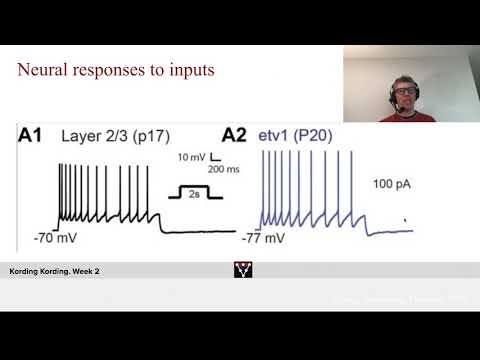

In [192]:
#@title Video: Linear Regression and Neuroscience

try: t4;
except NameError: t4=time.time()

video = YouTubeVideo(id="oQcrIgtqlXU", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Section 4.1: Linear Regression

Video available at https://youtube.com/watch?v=h5H8A3ZFuI4


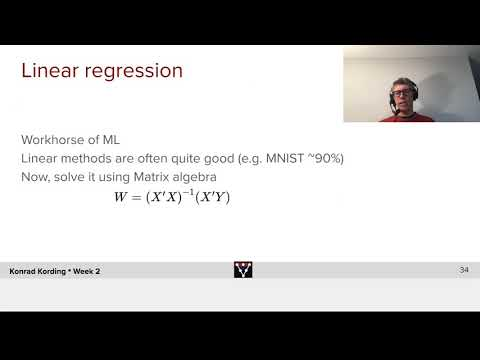

In [193]:
#@title Video: Linear Regression and Matrix Inversion
video = YouTubeVideo(id="h5H8A3ZFuI4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Generally, *regression* refers to a set of methods for modeling the relationship between one (or more) independent variable(s) and one (or more) dependent variable(s). Regression is commonly applied when we want to find the relationship between the dependent and the independent variables. For example, if we want to examine the relative impacts of age, gender, and diet (the independent variables) on height (the dependent variable). On the other hand, a regression can be used for predictive analysis. Thus the independent variables are also called predictors. When the model contains more than one predictor, then the method is called *multiple regression*, and if it contains more than one dependent variable called *multivariate regression*.

Regression problems pop up whenever we want to predict a numerical (usually continuous) value.

The independent variables are collected in a vector $\mathbf{x} \in \mathbb{R}^D$, where $D$ denotes the number of independent variables. Each variable influences differently the dependent variable by a weight factor, $w_{d}$. Thus, $\mathbf{w} \in \mathbb{R}^D$.

The multiple regression model can be written as:

\begin{equation}
y = w_{1}x_{1} + w_{2}x_{2} + \dots + w_{D}x_{D} + b = \sum_{d=1}^D \left(w_{d}x_{d} \right) + b
\end{equation}

Thus, the model can be written in matrix format as:

\begin{equation}
y = \begin{bmatrix} w_{1} & w_{2} & \dots & w_{D} \end{bmatrix} \begin{bmatrix} x_{1} \\ x_{2} \\ \vdots \\ x_{D} \\ \end{bmatrix} + b
\end{equation}

Which can be written in a compact form as:
\begin{equation}
y = \mathbf{w}^{\text{T}}\mathbf{x} + b
\end{equation}

where $\text{w}$ is the weight and $b$ is the bias (also known as intercept). Notice that $x$ is a matrix with the independent variables in rows and different examples stack in columns.

First, lets plot our synthetic dataset, using $w=2.5$ and $b=1.2$. We will also add gaussian noise with standard deviation $\sigma$ to make the synthetic data more realistic.

\begin{equation}
y = \mathbf{w}^{\text{T}}\mathbf{x} + b + \epsilon
\end{equation}

where 

\begin{equation}
\epsilon \sim \mathcal{N}(\mu=0, \sigma)
\end{equation}

### Gaussian distribution

To refresh our memory, the probability density of a normal distribution with mean $\mu$ and standard deviation $\sigma$ is given by:

\begin{equation}
p(x)=\frac{1}{2\pi\sigma^{2}} \exp \left(-\frac{(x-\mu)^{2}}{2\sigma^{2}}\right)
\end{equation}


Here, we will start from the simplest case, where we want to perform regression using one predictor (**x**) and one dependent variable (**y**). Thus, the model is given by the formula:

\begin{equation}
y = w_{1}x + b + \epsilon
\end{equation}



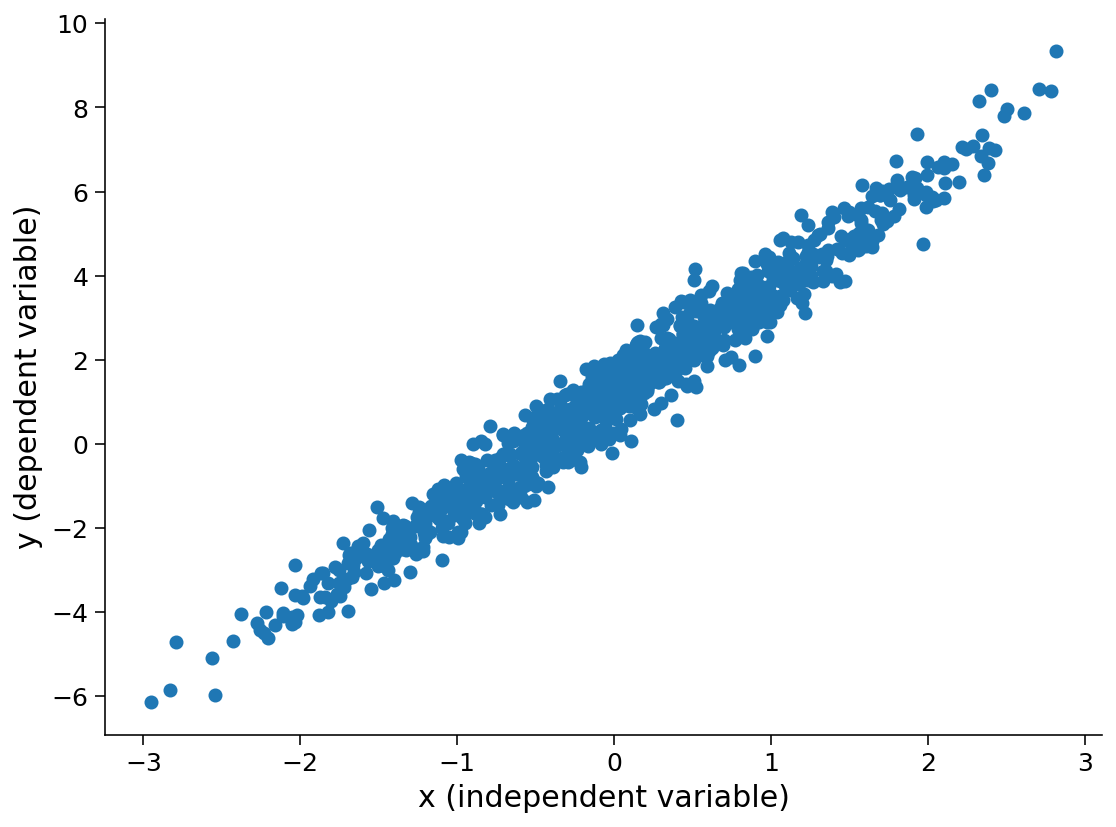

In [194]:
# This is the code block to generate random data for linear regression

original_w = torch.tensor([2.5]).reshape(-1,1)
original_b = 1.2
N = 1000  # number of examples
X, y = synthetic_dataset(original_w, original_b, num_examples=N, sigma=0.5)

plt.figure()
plt.scatter(X, y)
plt.xlabel('x (independent variable)')
plt.ylabel('y (dependent variable)')
plt.show()

## Section 4.2: Vectorized regression

Now, having a lot of data, we can collect them in a matrix $\mathbf{X} \in \mathbb{R}^{D \times N}$,. Thus, linear regression takes the following form:

\begin{equation}
\mathbf{Y} = \mathbf{w}^{\text{T}}\mathbf{X} + b
\end{equation}

where broadcasting is applied in the summation, i.e., $b$ broadcasts in a $D$-dimensional vector with the values $b$ in every position. 

Let's write the code for our model.

### Exercise 4a: Write the linear regression model

In [195]:
def linear_regression(X, w, b):
  '''
  Linear regression model.
  
  Parameters
  ----------
  X : torch.tensor
      design matrix.
  w : torch.tensor
      weights.
  b : torch.tensor
      bias.
  
  Returns
  -------
  torch.tensor
    predicted values.
  
  '''
  reg = torch.matmul(w.T, X) + b
  return reg

# uncomment the lines below to test your function
print(linear_regression(X[:,0].reshape(1,-1), original_w, original_b))

tensor([[0.8370]])


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W2_PyTorchDLN/solutions/W2_Tutorial1_Solution_Ex04a.py)

*Example output:*  

`tensor([[0.8370]])`

## Section 4.3: Loss function
First, we need to determine a measure of fitness. In simple words, we want to quantify if our model performs good or bad given some parameters $w$ and $b$. The so-called *loss function* quantifies the distance between the real and predicted values of the target. The loss will usually be a non-negative float number (as you will see later on, some applications can also contain negative losses). Small values are better and perfect predictions incur a loss of 0. The most popular loss function in regression problems is the **squared error**. When our prediction for an example $\mathbf{x}^{[i]}$ is $\hat{y}^{[i]}$ and its corresponding true value is $y^{[i]}$ , the squared error is given by:

\begin{equation}
l^{[i]}=\left(\hat{y}^{[i]} - y^{[i]}\right)^{2}
\end{equation}

Usually, our datset consits of lots of data, thus we sum up all individual squred error. Generally, we take out the average of all these erros, thus, gien that we have $N$ data points the *mean squared error* (MSE) is given by:

\begin{align}
L(\mathbf{w}, b) &{}= \frac{1}{N} \sum_{i=1}^{N} l^{[i]} \\ 
&{}= \frac{1}{N} \sum_{i=1}^{N} \left(\hat{y}^{[i]} - y^{[i]}\right)^{2} \\ 
&{}=  \frac{1}{N} \sum_{i=1}^{N} \left(\mathbf{w}^{\text{T}}\mathbf{x}^{[i]} + b - y^{[i]}\right)^{2}
\end{align}

Our aim here is to choose the parameters so that the error will be minimized. In mathematical terms, this is translated into a minimization problem with respect to parameters $\mathbf{w}$ and $b$:

\begin{equation}
\mathbf{w^{*}}, b^{*} = \underset{\mathbf{w},b}{\mathrm{argmin}} \left( L(\mathbf{w}, b) \right)
\end{equation}

Let's implement a function that calculates the mean squared error.

### Exercise 4b: Squared Error calculation

In [196]:
def squared_error(y_hat, y):
  '''
  Squared error loss function.
  
  Parameters
  ----------
  y_hat : torch.tensor
      predicted values.
  y : torch.tensor
      true values.
  
  Returns
  -------
  err: FLOAT
       the squared error (loss)
  
  '''
  err = (y_hat - y.reshape(y_hat.shape)) ** 2
  return err

# uncomment the lines below to test your function
print(squared_error(torch.tensor([2, 1, 7]), torch.tensor([1,-1, 7.5])))

tensor([1.0000, 4.0000, 0.2500])


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W2_PyTorchDLN/solutions/W2_Tutorial1_Solution_Ex04b.py)

*Example output:*  

`tensor([1.0000, 4.0000, 0.2500])`

## Section 4.3.1 Analytic Solution by Matrix Inversion

As you can see from the equation above, linear regression is a relatively simple optimization problem. Unlike most other models that we will see in this course, linear regression can be solved analytically by applying a simple formula.

To further simplify things, we can subsume the bias $b$  into the parameter  $\textbf{w}$ by appending an extra fake dimension equal to one to our data points $\textbf{x}$. Thus, the vectors $\textbf{x} \in \mathbb{R}^{D+1}$.

So, using matrix notation, the optimization problem is given by:

\begin{align}
\mathbf{w^{*}} &{}= \underset{\mathbf{w}}{\mathrm{argmin}} \left( ||\textbf{Y} - \textbf{X}\textbf{w}||^2  \right) \\
&{}= \underset{\mathbf{w}}{\mathrm{argmin}} \left( \left( \textbf{Y} - \textbf{X}\textbf{w}\right)^{\text{T}} \left( \textbf{Y} - \textbf{X}\textbf{w}\right) \right)
\end{align}

where $\textbf{X} \in \mathbb{R}^{N \times D}$, the so-called design matrix.

Thus, the minimization problem is to set the derivative of the loss with respect to $\textbf{w}$ to zero.

\begin{equation}
\frac{\partial L(\textbf{w})}{\partial \textbf{w}} = 0
\end{equation}

Assuming that $\textbf{X}^{\text{T}}\textbf{X}$ is full-rank and thus its inverse exists (implying that $N>D$ and the rows are not all linearly dependent:

\begin{equation}
\textbf{w}^{\textbf{*}} = \left( \textbf{X}^{\text{T}}\textbf{X} \right)^{-1}\textbf{X}^{\text{T}}\textbf{Y}
\end{equation}

**Note**: for the analytic proof, see the [Appendix](#proof).

### Exercise 4c: Write the analytical solution of the linear regression

So, let's write a function that calculates the analytic solution of the linear regression problem given that we have a dataset $X$ and the target variables $y$.

*Hint*: What is the determinant (`np.linalg.det`) of a non-invertible matrix?

In [197]:
def analytical_sol(X, y):
  '''
  Squared error loss function.
  
  Parameters
  ----------
  X : numpy.ndarray (float)
      design matrix with dimensions NxD, D: features, N: examples.
  y : numpy.ndarray (float)
      target values.
  
  Returns
  -------
  params: numpy.ndarray
          the parameters w, and bias (last element)
          if `X.T @ X` is singular, returns nothing.
  '''

  # Check if the inverse exists, unless print error.
  params = []
  if np.linalg.det(X.T @ X) != 0:
    params = np.linalg.inv(X.T @ X) @ X.T @ y
  else:
    print('LinAlgError. Matrix is Singular. No analytical solution.')

  return (params)


# tiny dataset
alpha, beta = -2.0, 1.4
xsynth = np.linspace(-1, 1, 10).reshape(-1, 1)  # 100 examples, in 10D space
ysynth = alpha*xsynth + beta  # target values
xsynth_append = np.hstack((xsynth, np.ones((10, 1))))  # Append a column with `1`

# uncomment the lines below to test the analytical solution
params = analytical_sol(xsynth_append, ysynth)
print(f'Original: alpha={alpha} and beta={beta}')
print(f'Estimated: alpha={params[0].item()} and beta={params[1].item()}')

Original: alpha=-2.0 and beta=1.4
Estimated: alpha=-1.9999999999999998 and beta=1.4000000000000001


[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W2_PyTorchDLN/solutions/W2_Tutorial1_Solution_Ex04c.py)

*Example output:*  

```
Original: alpha=-2.0 and beta=1.4
Estimated: alpha=-1.9999999999999998 and beta=1.4000000000000001
```

## Section 4.4: Gradient descent

Linear regression has a closed-form solution; however, this is not the case in most machine learning applications. When we cannot solve the models analytically, it turns out that we can still train models effectively in practice.

The key technique for optimizing nearly any deep learning model consists of iteratively reducing the error by updating the direction's parameters that incrementally lowers the loss function. This algorithm is called *gradient descent*.

The most naive application of gradient descent consists of taking the derivative of the loss function, an average of the losses computed on every single example in the dataset.

We define the gradient of a multi-variable function $f(\theta)$ as $$\nabla f(\theta) = \begin{bmatrix} \dfrac{\partial f(\theta)}{\partial \theta_0} \\ \dfrac{\partial f(\theta)}{\partial \theta_1} \\ \vdots \\ \dfrac{\partial f(\theta)}{\partial \theta_D} \\ \end{bmatrix}$$


Gradient Descent attempts to find the minima of a given function $f(\theta)$ by descending to the gradient's opposite direction.

It updates the parameters in an iterative fashion in the opposite direction of the gradient. First, we need an initial guess $x_0$ of the solution (often this is randomly initialized). Then, we calculate the gradient with the function evaluated at $x_0$. The update rule is as follows: 
\begin{equation}
\theta^{\text{new}} = \theta^{\text{old}} - \eta \nabla f(\theta^{\text{old}})
\end{equation}
where $\eta$ is the learning rate, how fast or slow the model learns.

In our simple example, our model consists of two parameters, $w$ and $b$, thus, the gradient descent can be written:

\begin{equation}
w \leftarrow w - \eta \frac{\partial }{\partial w} L(w,b) \\
b \leftarrow b - \eta \frac{\partial }{\partial b} L(w,b)
\end{equation}

We start with $w=0$ and $b=0$.

In [198]:
def gradient_descent(w, b, lr):
  '''
  gradient_descent algorithm.
  
  Parameters
  ----------
  w : torch.tensor
      weights.
  b : torch.tensor
      bias.
  lr : FLOAT
      learning rate.
  
  Returns
  -------
  w, b.
  
  '''
  with torch.no_grad():
    w -= w.grad * lr
    b -= b.grad * lr
    # Set gradient to zero to flush the cache
    w.grad.zero_()
    b.grad.zero_()

  return (w, b)

## Section 4.5: Training

Here, we will write from scratch the training loop. First, we choose the learning rate and the number of epochs, and we define the loss function. Then, we initialize the parameters. We use a list `losses` to record the mean-squared error after each **epoch** (with **epoch**, we denote a full pass of the data set through the network).

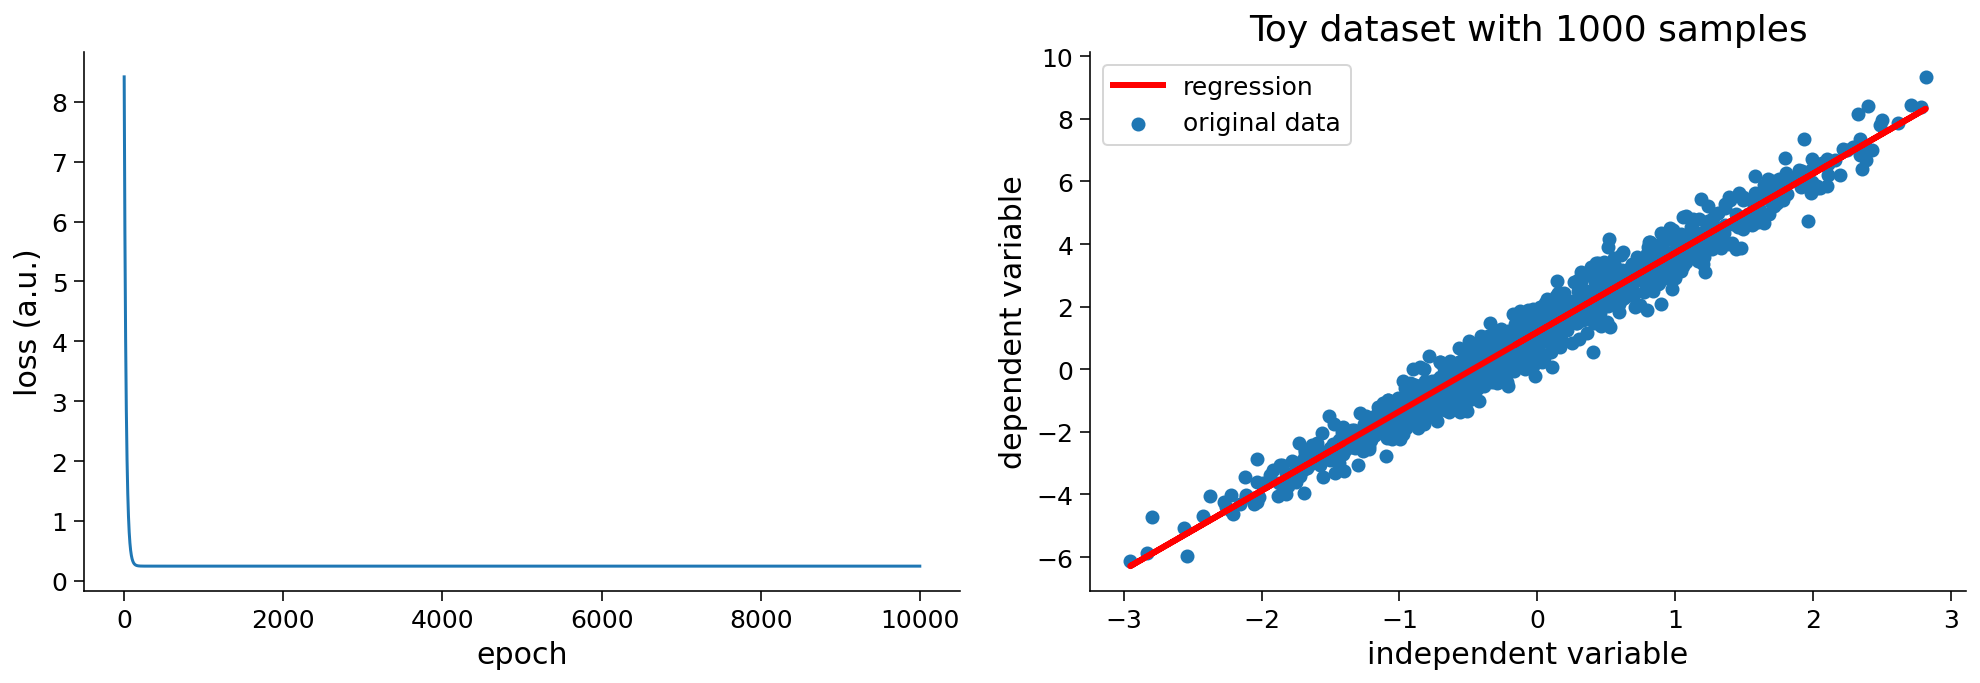

In [199]:
lr = 1e-2 # learning rate
# lr = 1e-5 # learning rate
num_epochs = 10000  # number of epochs (updates)
net = linear_regression
loss = squared_error

w = torch.zeros(1, requires_grad = True)
b = torch.zeros(1, requires_grad = True)

losses = []

epoch_range = trange(num_epochs, desc='loss: ', leave=True)

for epoch in epoch_range:
  if losses:
    epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
    epoch_range.refresh() # to show immediately the update

  y_hat = net(X, w, b)
  l = loss(y_hat, y).mean()  # Loss in `X` and `y`
  
  # Compute gradient on `l` with respect to `w`, `b`
  l.backward()
  w, b = gradient_descent(w, b, lr)  # Update parameters using their gradient
  
  losses.append(l)

  time.sleep(0.01)

w_train = w
b_train = b
y_hat = net(X, w_train, b_train).reshape(-1,1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses)
plt.xlabel('epoch')
plt.ylabel('loss (a.u.)')

plt.subplot(1, 2, 2)
plt.scatter(X, y, label='original data')
plt.plot(X.reshape(-1,1), y_hat.detach(), label='regression',
         color='red', linewidth=3.0)
plt.xlabel('independent variable')
plt.ylabel('dependent variable')
plt.title(f'Toy dataset with {N} samples')
plt.legend()
plt.show()

**Student response**: Now, go back and change the learning rate to a bigger number and see what happens. Change the learning rate to a smaller number and see what happens. What happens if you change the number of epochs to a higher or lower value? Why do you think this is happening? 

In [200]:
lr_epochs_vs_convergence = "Changing the learning rate changes to 1e-5 from 1e-2 means that the weights are no longer learned. The loss continues to decrease but doesn't quite reach a minima.  With 1e-2 as the learning rate, increasing the number of epochs has no impact since the weights are already learned. " #@param {type:"string"}

---

# Section 5: Linear regression using Pytorch's Sequential class

In [201]:
#@markdown I'm a time tracker, please run me.

try: t5;
except NameError: t5=time.time()

Now, let's implement the same model but here using a PyTorch model. When we implemented linear regression from scratch, we defined our model parameters explicitly and coded the calculations to produce output using basic linear algebra operations. You should know how to do this.

But once your models get more complex, and once you have to do this nearly every day, you will be glad for the assistance. The situation is similar to coding up your own blog from scratch. Doing it once or twice is rewarding and instructive, but you would be a lousy web developer if every time you need a blog, you spent a month reinventing the wheel.

We can use a framework’s predefined layers for standard operations, which allow us to focus especially on the layers used to construct the model rather than focusing on the implementation. We will first define a model variable net, which will refer to the Sequential class instance. The Sequential class defines a container for several layers that will be chained together. Given input data, a Sequential instance passes it through the first layer, passing the output as the second layer’s input and so forth. Our model consists of only one layer in the following example, so we do not really need Sequential. But since nearly all of our future models will involve multiple layers, we will use it anyway to familiarize you with the most standard workflow.

Recall the architecture of a single-layer network. The layer is said to be fully-connected because each of its inputs is connected to each of its outputs through matrix-vector multiplication.

The only difference is that here we use the design matrix in a transposed form; $ \mathbf{X} \in \mathbb{R}^{N \times D} $, thus the model is defined as:

\begin{equation}
\mathbf{Y} = \mathbf{X} \mathbf{w} + b
\end{equation}

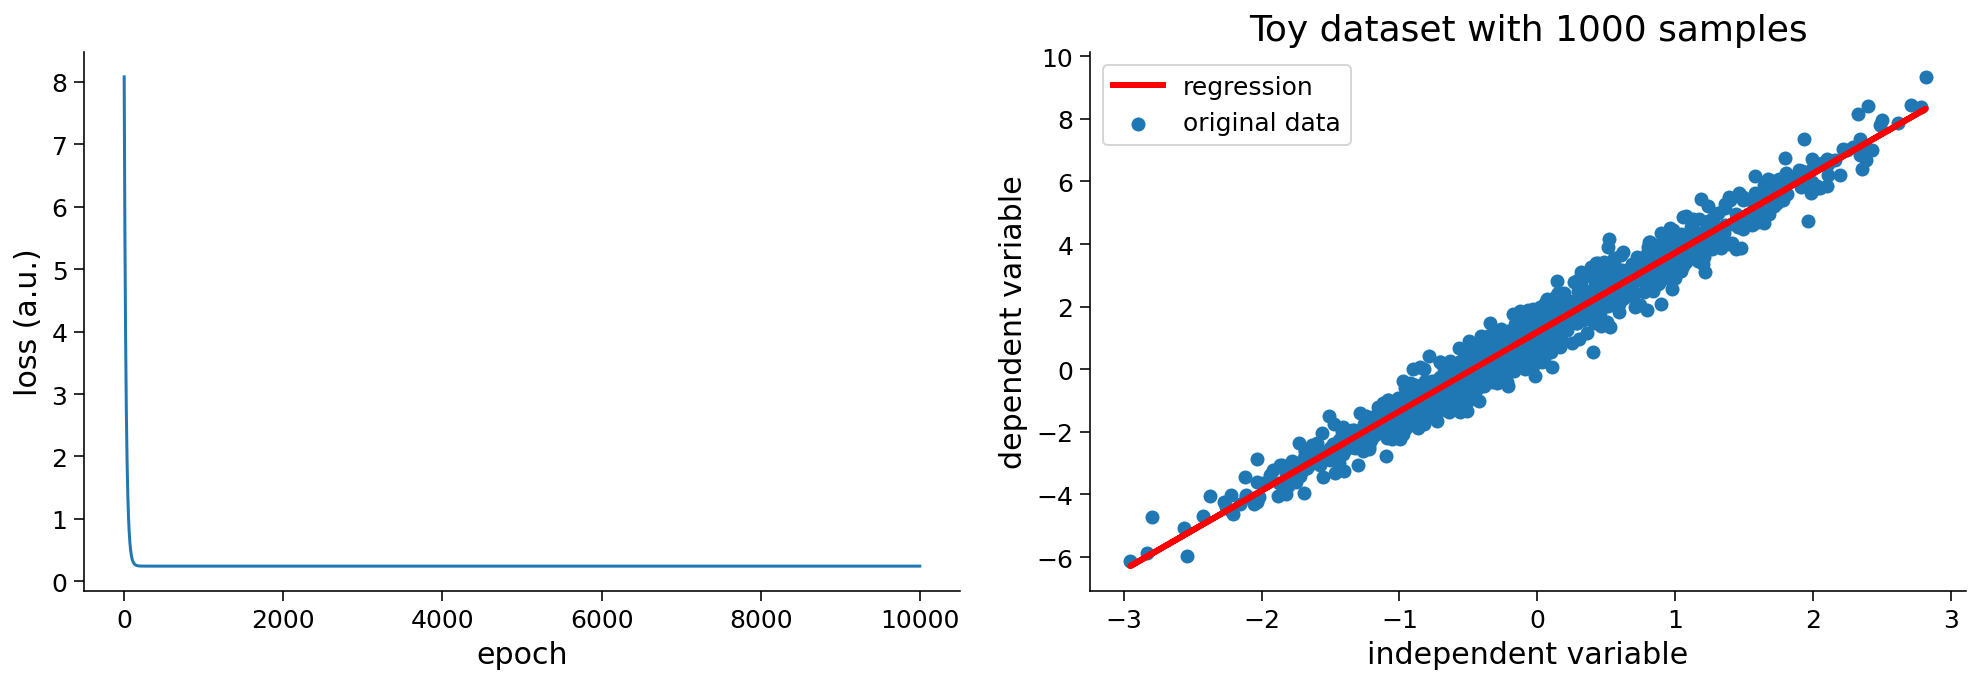

In [203]:
net = nn.Sequential(nn.Linear(1, 1))

net[0].weight.data.fill_(0)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)

losses = []

epoch_range = trange(num_epochs, desc='loss: ', leave=True)

for epoch in epoch_range:
  if losses:
    epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
    epoch_range.refresh() # to show immediately the update

  l = loss(net(X.T) , y)
  l.backward()
  optimizer.step()
  optimizer.zero_grad()
  l = loss(net(X.T), y)
  losses.append(l)

y_hat = net(X.T).reshape(-1,1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), losses)
plt.xlabel('epoch')
plt.ylabel('loss (a.u.)')

plt.subplot(1, 2, 2)
plt.scatter(X, y, label='original data')
plt.plot(X.reshape(-1,1), y_hat.detach(), label='regression',
         color='red', linewidth=3.0)
plt.xlabel('independent variable')
plt.ylabel('dependent variable')
plt.title(f'Toy dataset with {N} samples')
plt.legend()
plt.show()

## Section 5.1: Model evaluation

We compare the model parameters learned by training the given data-set and the actual parameters generated by our dataset. To access parameters, we first access the layer that we need from the model (i.e., `net`) and then access that layer’s weights and bias. As in our from-scratch implementation, note that our estimated parameters are close to their ground-truth counterparts.

In [204]:
w_pytorch = net[0].weight.data
print('error in estimating w:', original_w - w_pytorch.reshape(original_w.shape))
b_pytorch = net[0].bias.data
print('error in estimating b:', original_b - b_pytorch)

print(f'Original w: {original_w}, from-scratch: {w_train.detach()}, pytorch: {w_pytorch}')
print(f'Original b: {original_b}, from-scratch: {b_train.detach()}, pytorch: {b_pytorch}')


X = X.cpu().detach().numpy()
y = y.cpu().detach().numpy()

# We append a row with ones
X_append = np.vstack((X, np.ones((1,1000))))

# Check if the inverse matrix exists!!
params = analytical_sol(X_append.T, y)
if len(params) != 0:
  print(f'Original w: {original_w}, analytical: {params[0]}')
  print(f'Original b: {original_b}, analytical: {params[1]}')

error in estimating w: tensor([[-0.0301]])
error in estimating b: tensor([0.0153])
Original w: tensor([[2.5000]]), from-scratch: tensor([2.5301]), pytorch: tensor([[2.5301]])
Original b: 1.2, from-scratch: tensor([1.1847]), pytorch: tensor([1.1847])
Original w: tensor([[2.5000]]), analytical: [2.53014445]
Original b: 1.2, analytical: [1.18474046]


## Section 5.2: More features than the number of examples

Video available at https://youtube.com/watch?v=_uhMofhfYno


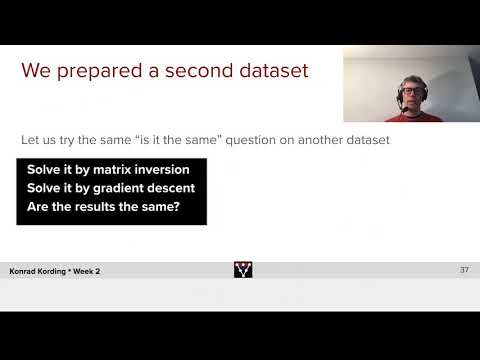

In [205]:
#@title Video: Linear Regression with More Dimensions than Data

video = YouTubeVideo(id="_uhMofhfYno", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

But, what if we do not have enough data? And what about if the dataset is linearly dependent?

In [206]:
# Generate a second dataset with D>>N

original_w = torch.randn(200, 1).reshape(-1,1)
original_b = 1.2
N = 10 # number of examples
X, y = synthetic_dataset(original_w, original_b, num_examples=N, sigma=0.5)

print(f'The dataset has N={X.shape[1]} examples in the {X.shape[0]}D space!')

The dataset has N=10 examples in the 200D space!


torch.Size([1, 200])


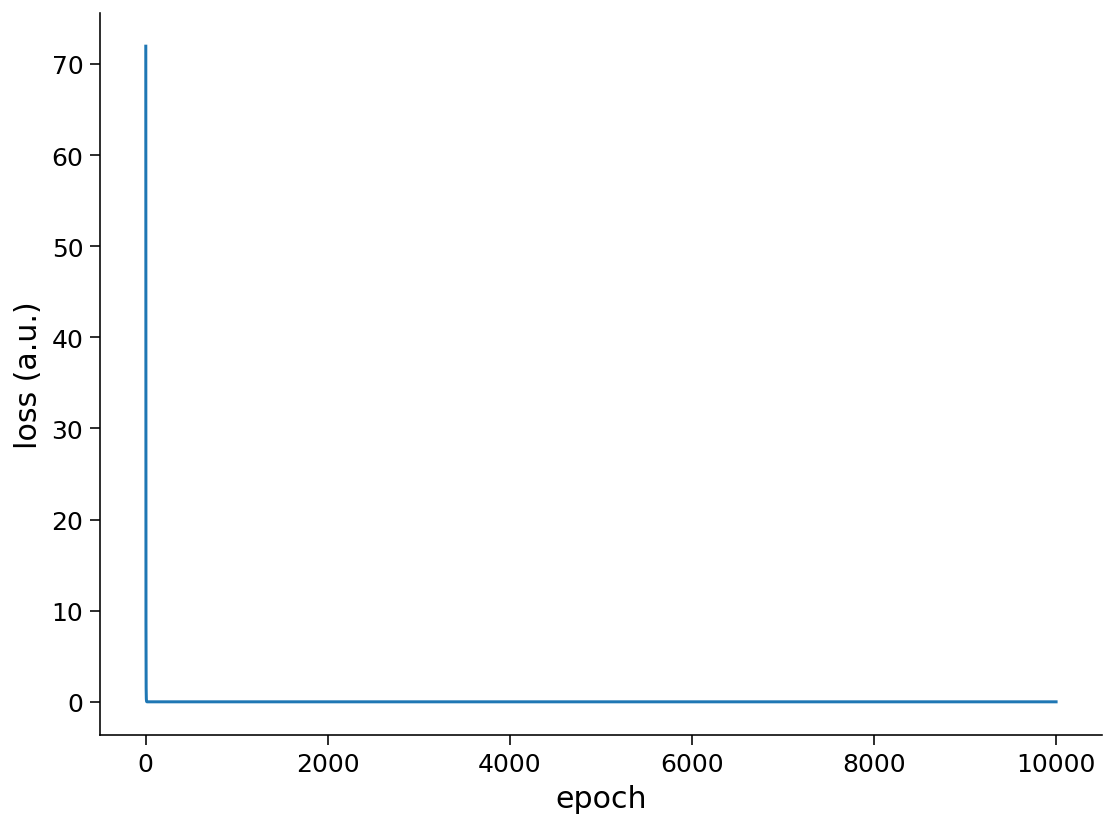

In [207]:
# Model construction
net = nn.Sequential(nn.Linear(X.shape[0], 1))

# Parameter initialization to zero
net[0].weight.data.fill_(0)
net[0].bias.data.fill_(0)
print(net[0].weight.shape)

loss = nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)

losses = []

epoch_range = trange(num_epochs, desc='loss: ', leave=True)

for epoch in epoch_range:
  if losses:
    epoch_range.set_description("loss: {:.6f}".format(losses[-1]))
    epoch_range.refresh() # to show immediately the update

  l = loss(net(X.T), y)
  l.backward()
  optimizer.step()
  optimizer.zero_grad()
  l = loss(net(X.T), y)
  losses.append(l)

y_hat = net(X.T).reshape(-1,1)

plt.figure()
plt.plot(range(num_epochs), losses)
plt.xlabel('epoch')
plt.ylabel('loss (a.u.)')
plt.show()

Let's compute the analytic solution.

In [208]:
# Append a row with ones and take the transpose
X_append = np.vstack((X.detach(), np.ones((1, X.shape[1])))).T

# Analytical solution
params = analytical_sol(X_append, y.cpu().detach().numpy())
if len(params) != 0:
  print(f'Original w: {original_w}, analytical: {params[0]}')
  print(f'Original b: {original_b}, analytical: {params[1]}')


LinAlgError. Matrix is Singular. No analytical solution.


Video available at https://youtube.com/watch?v=FpcSTi9YITc


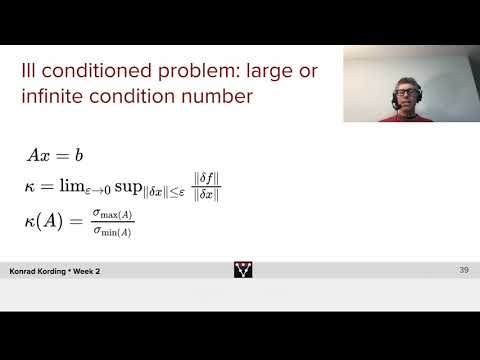

In [209]:
#@title Video: Condition Numbers

video = YouTubeVideo(id="FpcSTi9YITc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Wrap up

## Submit responses

In [210]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**

import time
import numpy as np
from IPython.display import IFrame

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()
try: t6;
except NameError: t6 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = ""
try: my_w1_upshot;
except NameError: my_w1_upshot = ""
try: my_expectations;
except NameError: my_expectations = ""
try: deep_learning_benchmark;
except NameError: deep_learning_benchmark = ""
try: derivative_free_opt_alg;
except NameError: derivative_free_opt_alg = ""
try: autograd_uses;
except NameError: autograd_uses = ""
try: lr_epochs_vs_convergence;
except NameError: lr_epochs_vs_convergence = ""

times = [(t-t0) for t in [t1,t2,t3,t4,t5,t6]]

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "my_w1_upshot": my_w1_upshot,
          "expectations": my_expectations,
          "deep_learning_benchmark": deep_learning_benchmark,
          "derivative_free_opt_alg": derivative_free_opt_alg,
          "autograd_uses": autograd_uses,
          "lr_epochs_vs_convergence": lr_epochs_vs_convergence}
          # "cumulative_times": times}

src = "https://airtable.com/embed/shrjWLVOEJF0CA3up?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [211]:
display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))

---
<a name="proof"></a>
# Appendix: Linear Regression analytic solution - Proof

\begin{align}
\frac{\partial L(\textbf{w})}{\partial \textbf{w}} &{}= 0 \\
\frac{\partial }{\partial \textbf{w}}\left( \left( \textbf{Y} - \textbf{X}\textbf{w}\right)^{\text{T}} \left( \textbf{Y} - \textbf{X}\textbf{w}\right) \right) &{} = 0 \\
\frac{\partial }{\partial \textbf{w}}\left( \left( \textbf{Y}^{\text{T}} - \left( \textbf{X}\textbf{w} \right)^{\text{T}}\right) \left( \textbf{Y} - \textbf{X}\textbf{w}\right) \right) &{} = 0 \\
\frac{\partial }{\partial \textbf{w}} \left( \textbf{Y}^{\text{T}}\textbf{Y} -
\left( \textbf{X}\textbf{w} \right)^{\text{T}}\textbf{Y} - \textbf{Y}^{\text{T}}\left( \textbf{X}\textbf{w}\right)+ \textbf{w}\textbf{X}^{\text{T}}\textbf{X}\textbf{w} \right)&{}= 0
\end{align}

Here, we need to make some simplifications on the second term in the left-hand side. We know that $\textbf{X} \in \mathbb{R}^{N \times D+1}, \textbf{w} \in \mathbb{R}^{D+1 \times 1}$, therefore their product $\in \mathbb{R}^{N \times 1}$. Thus, the dimensions of the second order is $1$, i.e., $ \left( \textbf{X}\textbf{w} \right)^{\text{T}} \in \mathbb{R}$. This means that the second order is a scalar.

Thus, we can substitute with its transpose, i.e., $\left( \left( \textbf{X}\textbf{w} \right)^{\text{T}} \textbf{Y} \right)^{\text{T}} = \textbf{Y}^{\text{T}} \left( \textbf{X}\textbf{w} \right)$. So the derivative is simplified in:

\begin{align}
\frac{\partial }{\partial \textbf{w}} \left( \textbf{Y}^{\text{T}}\textbf{Y} -\textbf{Y}^{\text{T}} \left( \textbf{X}\textbf{w} \right) - \textbf{Y}^{\text{T}} \left( \textbf{X}\textbf{w} \right) + \textbf{w}^{\text{T}}\textbf{X}^{\text{T}}\textbf{X}\textbf{w} \right)&{}= 0 \\
\frac{\partial }{\partial \textbf{w}} \left( \textbf{Y}^{\text{T}}\textbf{Y} -2\textbf{Y}^{\text{T}} \left( \textbf{X}\textbf{w} \right) + \textbf{w}^{\text{T}}\textbf{X}^{\text{T}}\textbf{X}\textbf{w} \right)&{}= 0 \\
\frac{\partial }{\partial \textbf{w}} \left( \textbf{Y}^{\text{T}}\textbf{Y} -2\left( \textbf{X}^{\text{T}}\textbf{Y} \right)^{\text{T}} \textbf{w} + \textbf{w}^{\text{T}}\textbf{X}^{\text{T}}\textbf{X}\textbf{w} \right)&{}= 0 \\
-2\textbf{X}^{\text{T}}\textbf{Y} + 2\textbf{X}^{\text{T}}\textbf{X}\textbf{w} &{}= 0
\end{align}

Assuming that $\textbf{X}^{\text{T}}\textbf{X}$ is full-rank and thus its inverse exists (implying that $N>D$ and the rows are not all linearly dependent:

\begin{equation}
\textbf{w}^{\textbf{*}} = \left( \textbf{X}^{\text{T}}\textbf{X} \right)^{-1}\textbf{X}^{\text{T}}\textbf{Y}
\end{equation}


For the solution, we have used the following identities:

*Derivative of a linear function*

\begin{equation}
\frac{\partial }{\partial \vec{x}} \vec{\alpha}\vec{x} = \frac{\partial }{\partial \vec{x}} \vec{\alpha}^{\text{T}}\vec{x} = \frac{\partial }{\partial \vec{x}} \vec{x}^{\text{T}} \vec{\alpha} = \vec{\alpha}
\end{equation}

*(Think of calculus: $\frac{d}{dx}(\alpha x)=\alpha$)*

*Derivative of a quadratic function*

\begin{equation}
\frac{\partial }{\partial \vec{x}} \vec{x}^{\text{T}}A \vec{x} = (A + A^{\text{T}}) \vec{x}
\end{equation}

where if $A=A^{\text{T}}$, i.e., $A$ is symmetric, then

\begin{equation}
\frac{\partial }{\partial \vec{x}} \vec{x}^{\text{T}}A \vec{x} = 2A \vec{x}
\end{equation}

*(Think of calculus: $\frac{d}{dx}(\alpha x^2)=2 \alpha x$)*

